In [1]:
%load_ext autoreload
%autoreload 2
from lib.model import train_lgbm_fold_classif, plot_importances
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lib.constants import DATA_FOLDER, TMP_FOLDER, SUBMISSION_FOLDER
from lib.dataload import load_data
import numpy as np
from lib.utils import make_submission_from_hdf
df_train, df_target, df_test = load_data(read=True, reduce_mem=False)
df_train['is_train'] = 1
df_test['is_train'] = 0
train_test = pd.concat([df_train, df_test], sort=False)

/Users/benjaminfarcy/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


... Reading ...
-- Done


In [2]:
nmods_data = []
for param in train_test.columns:
    nmods = train_test[param].nunique()
    nmods_data.append(nmods)

df_nmods = pd.DataFrame(list(train_test.columns), columns=['param'])
df_nmods['nmods'] = nmods_data

sel_cols = list(set(df_nmods.columns) - set(['is_train', 'target']))

look_cols = list(df_nmods[sel_cols].sort_values('nmods').head(30)['param'].values[2:])

In [3]:
count_cols = []
for col in look_cols:
    colname = 'count_' + col
    count_cols.append(colname)
    tmp = (
        pd.DataFrame(train_test.groupby([col])['ID_code']
                     .count().reset_index()
                     .rename(columns={'ID_code': colname}))
    )
    train_test = train_test.merge(tmp, on=[col])

In [4]:
for col in count_cols:
    df_a = pd.cut(train_test[col], train_test[col].nunique()).value_counts().sort_index()
    df_a = df_a.reset_index().rename(columns={'index': 'bin'}).reset_index()
    df_a['diff'] = df_a[col].diff().fillna(0)
    df_a['delta_0'] = np.around((df_a[col] - 0 )/ (df_a['index'] + 1), decimals=0)
    
    step = (train_test[col].max()-train_test[col].min())/train_test[col].nunique()
    tmp2 = pd.DataFrame(train_test[col].drop_duplicates()).sort_values(by=col)
    group_col = 'group_' + col
    tmp2[group_col] = tmp2[col].apply(lambda x: int(df_a.iloc[np.minimum(int(x/step),
                                                  train_test[col].nunique()-1), 4]))
    train_test = train_test.merge(tmp2, on=col)

In [11]:
remove_cols = ['target', 'ID_code', 'is_train']
selected_cols = list(set(df_train.columns) - set(remove_cols))
print(selected_cols)

['var_42', 'var_133', 'var_113', 'var_14', 'var_141', 'var_37', 'var_91', 'var_184', 'var_77', 'var_8', 'var_199', 'var_2', 'var_49', 'var_118', 'var_128', 'var_45', 'var_66', 'var_180', 'var_196', 'var_23', 'var_170', 'var_139', 'var_156', 'var_174', 'var_159', 'var_10', 'var_5', 'var_47', 'var_160', 'var_36', 'var_16', 'var_52', 'var_81', 'var_87', 'var_51', 'var_33', 'var_117', 'var_151', 'var_125', 'var_59', 'var_35', 'var_143', 'var_112', 'var_134', 'var_166', 'var_121', 'var_122', 'var_153', 'var_74', 'var_140', 'var_53', 'var_162', 'var_93', 'var_157', 'var_88', 'var_108', 'var_123', 'var_19', 'var_131', 'var_119', 'var_173', 'var_161', 'var_12', 'var_48', 'var_107', 'var_13', 'var_179', 'var_97', 'var_34', 'var_176', 'var_175', 'var_190', 'var_71', 'var_185', 'var_198', 'var_41', 'var_147', 'var_76', 'var_111', 'var_163', 'var_120', 'var_85', 'var_99', 'var_46', 'var_142', 'var_103', 'var_20', 'var_7', 'var_11', 'var_95', 'var_168', 'var_152', 'var_17', 'var_96', 'var_65', 'var

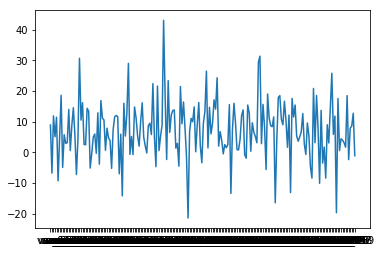

In [16]:
plt.plot(df_train.iloc[0, 2:-1])

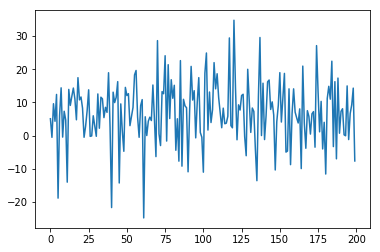

In [38]:
plt.plot(np.arange(0, 200), df_train.iloc[10, 2:-1])

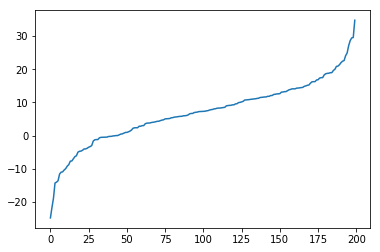

In [37]:
plt.plot(np.arange(0, 200), df_train.iloc[10, 2:-1].sort_values())

In [45]:
help(pd.DataFrame.var)

Help on function var in module pandas.core.frame:

var(self, axis=None, skipna=None, level=None, ddof=1, numeric_only=None, **kwargs)
    Return unbiased variance over requested axis.
    
    Normalized by N-1 by default. This can be changed using the ddof argument
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
    skipna : boolean, default True
        Exclude NA/null values. If an entire row/column is NA, the result
        will be NA
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series
    ddof : int, default 1
        Delta Degrees of Freedom. The divisor used in calculations is N - ddof,
        where N represents the number of elements.
    numeric_only : boolean, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    
    Returns
   

In [46]:
# columnwise features
train_test['min_col'] = train_test[selected_cols].min(axis=1)
train_test['max_col'] = train_test[selected_cols].max(axis=1)
train_test['std_col'] = train_test[selected_cols].std(axis=1)
train_test['var_col'] = train_test[selected_cols].var(axis=1)
train_test['mean_col'] = train_test[selected_cols].mean(axis=1)
train_test['median_col'] = train_test[selected_cols].median(axis=1)

In [47]:
print("- Resplit train/test")
train = train_test[train_test['is_train'] == 1]
test = train_test[train_test['is_train'] == 0]

- Resplit train/test


# PCA stuff

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
remove_cols = ['target', 'ID_code', 'is_train']
selected_cols = list(set(df_train.columns) - set(remove_cols))
pca_result = pca.fit_transform(train_test[selected_cols])

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

print("Total explained variance:", np.sum(pca.explained_variance_ratio_))

plt.scatter(x=pca_result[:, 0], y=pca_result[:, 1], marker='.')

In [ ]:
train_test['pca_0_0'] = np.around(pca_result[:, 0], decimals=0)
train_test['pca_0_1'] = np.around(pca_result[:, 1], decimals=0)

In [ ]:
train_test['pca_0_0'].hist(bins=100)

In [ ]:
sns.jointplot(pca_result[:, 0], pca_result[:, 1], kind="hex", color="#4CB391")

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


X = pca_result

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Model

In [ ]:
print("- Resplit train/test")
train = train_test[train_test['is_train'] == 1]
test = train_test[train_test['is_train'] == 0]

In [ ]:
train.to_hdf('./data_tmp/new_train.hdf', 'df')
test.to_hdf('./data_tmp/new_test.hdf', 'df')

In [48]:
# Code
remove_cols = ['target', 'ID_code']
features = list(set(train.columns) - set(remove_cols))

importances, df_oof_preds, df_preds, filename = train_lgbm_fold_classif(train, test, features, train['target'],
                              repeat_cv=1, n_splits=4,
                              n_max_estimators=10000
                              )

== INIT ==
== START MODEL TRAIN
== REPEAT CV 0
==== CV 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.756295	valid_1's auc: 0.74343
[200]	training's auc: 0.798672	valid_1's auc: 0.785551
[300]	training's auc: 0.816852	valid_1's auc: 0.803552
[400]	training's auc: 0.831063	valid_1's auc: 0.816761
[500]	training's auc: 0.842086	valid_1's auc: 0.828669
[600]	training's auc: 0.850939	valid_1's auc: 0.836763
[700]	training's auc: 0.85677	valid_1's auc: 0.842279
[800]	training's auc: 0.862022	valid_1's auc: 0.847418
[900]	training's auc: 0.866966	valid_1's auc: 0.852158
[1000]	training's auc: 0.870854	valid_1's auc: 0.855682
[1100]	training's auc: 0.874278	valid_1's auc: 0.858292
[1200]	training's auc: 0.877069	valid_1's auc: 0.861333
[1300]	training's auc: 0.879924	valid_1's auc: 0.86482
[1400]	training's auc: 0.882923	valid_1's auc: 0.867839
[1500]	training's auc: 0.884856	valid_1's auc: 0.870069
[1600]	training's auc: 0.8865	valid_1's auc: 0.87151

[2400]	training's auc: 0.895153	valid_1's auc: 0.885728
[2500]	training's auc: 0.896261	valid_1's auc: 0.887008
[2600]	training's auc: 0.897012	valid_1's auc: 0.887813
[2700]	training's auc: 0.897895	valid_1's auc: 0.888887
[2800]	training's auc: 0.89847	valid_1's auc: 0.889291
[2900]	training's auc: 0.899026	valid_1's auc: 0.889967
[3000]	training's auc: 0.8997	valid_1's auc: 0.890394
[3100]	training's auc: 0.900488	valid_1's auc: 0.891075
[3200]	training's auc: 0.901081	valid_1's auc: 0.891585
[3300]	training's auc: 0.901474	valid_1's auc: 0.891797
[3400]	training's auc: 0.901936	valid_1's auc: 0.892368
[3500]	training's auc: 0.902451	valid_1's auc: 0.89272
[3600]	training's auc: 0.902953	valid_1's auc: 0.89328
[3700]	training's auc: 0.90324	valid_1's auc: 0.89362
[3800]	training's auc: 0.903622	valid_1's auc: 0.89396
[3900]	training's auc: 0.904159	valid_1's auc: 0.894507
[4000]	training's auc: 0.904597	valid_1's auc: 0.894842
[4100]	training's auc: 0.90495	valid_1's auc: 0.895231
[

4


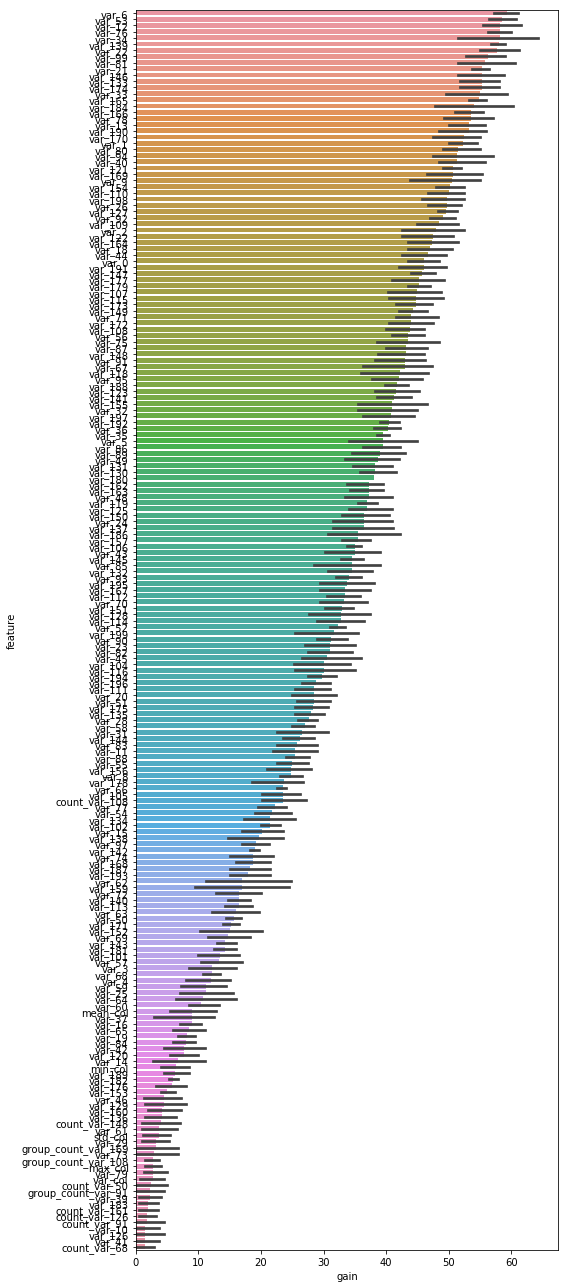

,feature,gain,model,fold,mean_gain
240,var_6,59,0,0,59.25
240,var_6,61,0,2,59.25
240,var_6,56,0,1,59.25
240,var_6,61,0,3,59.25
34,var_53,56,0,1,58.50
34,var_53,61,0,2,58.50
34,var_53,57,0,3,58.50
34,var_53,60,0,0,58.50
46,var_12,56,0,2,58.25
58,var_76,60,0,2,58.25


In [49]:
plot_importances(importances, num_features=200)

# Submissions

In [50]:
test['ID_code'].reset_index().head()

,index,ID_code
0,2,test_127606
1,4,test_69381
2,7,test_99014
3,8,test_35882
4,10,test_115968


In [55]:
df_pred_file = df_preds.merge(test['ID_code'].reset_index(), on=df_preds.index)[['ID_code', 0]].rename(columns={0:'target'})
df_pred_file.to_csv('./data_tmp/test_pred.csv', index=False)

In [ ]:
filename = 'preds_lgbm_classif_CV_0.88763_TR_0.98783'
filename = 'preds_lgbm_classif_CV_0.89800_TR_0.91159'


In [51]:
filename

'lgbm_classif_CV_0.89810_TR_0.91029.hdf'

In [57]:
make_submission_from_hdf('preds_lgbm_classif_CV_0.89810_TR_0.91029', test['ID_code'])

,ID_code,target
0,test_127606,0.033140
1,test_69381,0.307902
2,test_99014,0.021587
3,test_35882,0.083922
4,test_115968,0.016019
5,test_173387,0.010261
6,test_15480,0.033571
7,test_193058,0.102876
8,test_142036,0.290642
9,test_134024,0.012523


In [ ]:
preds_lgbm_classif_CV_0.89810_TR_0.91029.hdf